## Define imports

In [1]:
import requests
import shutil
from bs4 import BeautifulSoup
import json
import pandas as pd

# self created .py file
import ocr

# for conversion to hocr
import re
import io
from PIL import Image

In [2]:
import json
import os
import sys
import requests
import time

# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from io import BytesIO

## Web Scraping Images

Define images that need to be scraped. Get the page links of each image + metadata

In [53]:
base_url = 'https://transcription.si.edu'

# function to get the links of each page on the home project page
def get_page_links():
    '''
        purpose: this function gets the links of each project on the home project page. 
                 we need this to get the individual images in each project
        returns: 
            - the id of each project
    '''
    projects = []
    
    # iterate through each page
    pagenum = 1
    while True:
        response = requests.get(base_url + '/browse?filter=all&sort=notdone&page=' + str(pagenum))
        soup = BeautifulSoup(response.text)
        links = [link['href'] for link in soup.find_all('a') if 'project' in link['href']]
        links = list(set(links))
        if len(links) > 0:
            projects.extend(links)
            pagenum = pagenum + 1
        else:
            break
            
    # only get the ids
    projects = [project.split('/')[-1] for project in projects]
    return projects

# gets all the images in a project that have not yet been worked on
def get_project_images(project_id):
    '''
        purpose: this function gets the links of the image in the project
        params:
            - project_id: id of the project to retrieve the images for
        returns: 
            - the links of the images that have not been started on yet!
    '''
    pagenum = 0
    all_images = []
    while True:
        response = requests.get('https://transcription.si.edu/assets/' + str(project_id) + '/' + str(pagenum) + '?status=')
        soup = BeautifulSoup(response.text)
        if len(soup.find_all('img')) > 0:
#             images = [asset.find('img')['src'] for asset in soup.find_all('div', class_ = 'asset') if 'Start' in asset.text]
            images = [asset.find('img')['src'] for asset in soup.find_all('div', class_ = 'asset')]
            all_images.extend(images)
            pagenum = pagenum + 1
        else:
            break
    all_images = [img.replace('max_w=210', 'max_w=2000') for img in all_images]
    return all_images

In [54]:
projects = get_page_links()

In [55]:
# save the information into a dictionary
project_dict = {}

# iterate thru every project - this could use multiprocessing.. can be slow
for project in projects:
    
    # how is it going?
    print(project)
    
    # call the function
    images = get_project_images(project)
    
    # save to dict only if there are images that haven't been started on yet
    if len(images) > 0:
        project_dict[project] = images

26762
26753
23962
29922
29967
26771
29769
30329
26774
18067
30422
30362
23956
28704
18052
29259
29961
30359
29934
23953
30323


In [122]:
# save as json if necessary... since the process takes some time to run

# with open('data.json', 'w') as fp:
#     json.dump(project_dict, fp)

# with open('data.json', 'r') as fp:
#     data = json.load(fp)

## Hit the Azure Endpoint to get OCR Text

Use our custom defined function to get the text of the image. This works well, but we get back a json of bounding boxes & lines. doesn't give us larger bounding boxes (ie. news paper paragraph?)

In [175]:
image_url = 'https://transcription.si.edu/transcribe/23953/NASM-NASM.XXXX.0450-M0000176-00110'

In [176]:
json_response = ocr.get_text(image_url, '26771')

web hosted image


HTTPError: 401 Client Error: PermissionDenied for url: https://smithsonian-ocr.cognitiveservices.azure.com//vision/v3.0/read/analyze

In [209]:
analysis = json.loads(json_response)

## Use pytesseract to get hOCR output

Use pytesseract instead of Azure because we aren't limited in calls & don't have to convert to hOCR ourselves.

Change the output to hOCR to visualize on our front-end

In [19]:
import pytesseract
from pytesseract import image_to_pdf_or_hocr
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [43]:
# hocr_output = image_to_pdf_or_hocr('testing.jpg', extension='hocr')
# hocr = hocr_output.decode('utf-8')

In [120]:
# # this is the xml that needs to be passed to the front-end 
# BeautifulSoup(hocr, parser='xml')

In [121]:
import cv2

In [122]:
def get_image_url(input_url):
    try:
        r = requests.get(input_url)
        soup = BeautifulSoup(r.text)

        if 'project phaedra' in soup.text.lower().strip():
            pid = soup.find('div', {'id': 'transcription-asset-wrapper'})['data-idsid']
        else:
            pid = input_url.split('/')[-1]

        image_url = 'https://ids.si.edu/ids/deliveryService?max_w=2000&id=' + pid
        return image_url
    except Exception as e:
        print(e)
        return None

def get_hOCR(image_url):
    
    # load the image over requests
    response = requests.get(image_url, stream=True)
    img = Image.open(io.BytesIO(response.content))

    return img
    # get the hocr & parse. replace the image in the current text with the image_url
    hocr_output = image_to_pdf_or_hocr(img, extension='hocr')
    hocr = hocr_output.decode('utf-8')
    soup = BeautifulSoup(hocr, parser='xml')
    soup = BeautifulSoup(re.sub(r'image \"(.+?)\"', 'image ' + '"' + image_url + '"', str(soup)))
    return soup

In [123]:
image_url = get_image_url('https://transcription.si.edu/transcribe/23953/NASM-NASM.XXXX.0450-M0000176-00110')
soup = get_hOCR(image_url)

In [125]:
import numpy as np

In [132]:
import cv2

In [134]:
soup.save('image.png')

In [135]:
img = cv2.imread('image.png', 0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

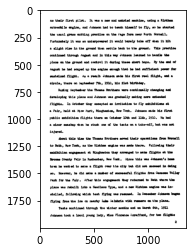

In [174]:
plt.imshow(thresh1, 'gray', vmin=0, vmax=255)

In [138]:
from matplotlib import pyplot as plt

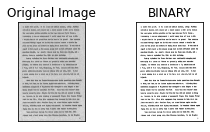

In [170]:
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(2):
    plt.subplot(2,3,i+1), plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.savefig('test2png.png', dpi=100)
plt.show()

# plt.set_size_inches(18.5, 10.5)


In [ ]:
img = cv2.imread('image.png', 0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)